<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Gradient Booster](#gradient_booster)<br>
    7.4  [Comparing Models](#comparing_model_performance)<br>
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
taxi_df = pd.read_csv('data/yellow_tripdata_2019-01.csv')

# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [3]:
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [4]:
taxi_df.shape

(7667792, 18)

In [5]:
taxi_data = taxi_df[['tpep_pickup_datetime',
                     'tpep_dropoff_datetime',
                     'passenger_count',
                     'trip_distance',
                     'RatecodeID',
                     'PULocationID',
                     'DOLocationID',
                     'payment_type',
                     'total_amount'
                    ]]

In [6]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667792 entries, 0 to 7667791
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   passenger_count        int64  
 3   trip_distance          float64
 4   RatecodeID             int64  
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           int64  
 8   total_amount           float64
dtypes: float64(2), int64(5), object(2)
memory usage: 526.5+ MB


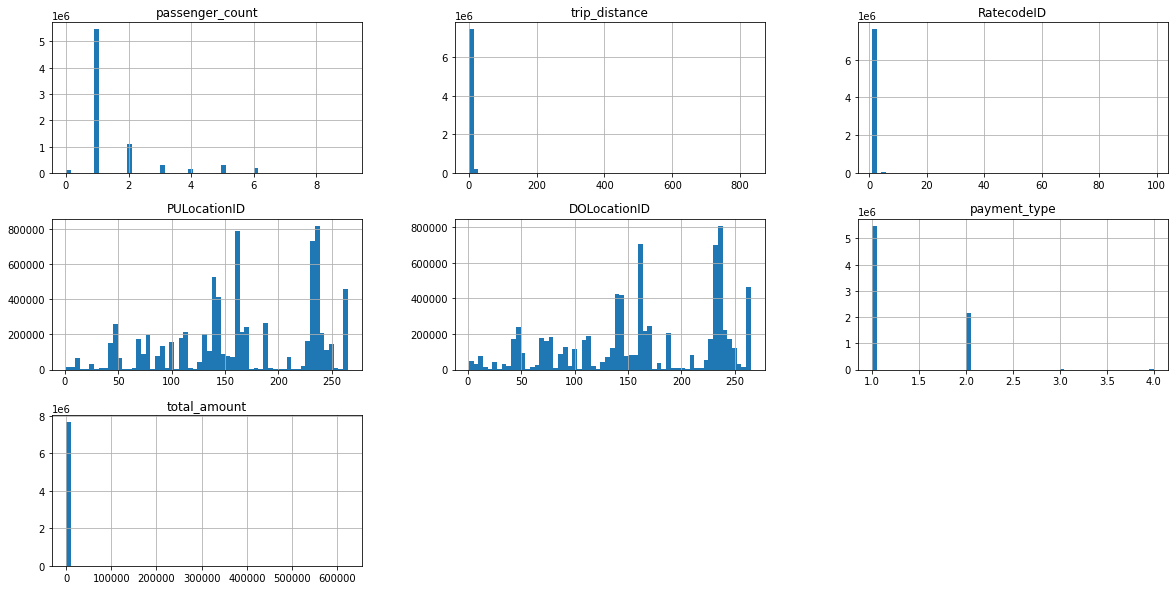

In [7]:
taxi_data.hist(figsize=(20,10), bins=60);

In [8]:
taxi_data['passenger_count'].value_counts()

1    5456121
2    1114106
5     323842
3     314721
6     200811
4     140753
0     117381
8         29
7         19
9          9
Name: passenger_count, dtype: int64

In [9]:
taxi_data['RatecodeID'].value_counts()

1     7430139
2      166090
5       54569
3       11801
4        4895
99        252
6          46
Name: RatecodeID, dtype: int64

#### RatecodeID possible values

1=Standard rate

2=JFK

3=Newark

4=Nassau or Westchester

5=Negotiated fare

6=Group ride

99=Probably missing RateID, just 252, probably can be dropped

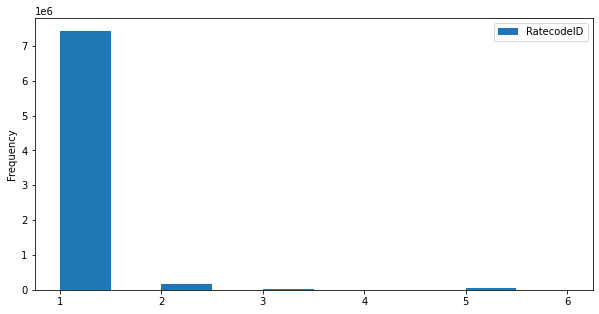

In [10]:
taxi_data[taxi_data['RatecodeID']<99].reset_index().plot(kind='hist',y='RatecodeID',x='index',figsize=(10,5));

In [11]:
taxi_data['payment_type'].value_counts()

1    5486027
2    2137415
3      33186
4      11164
Name: payment_type, dtype: int64

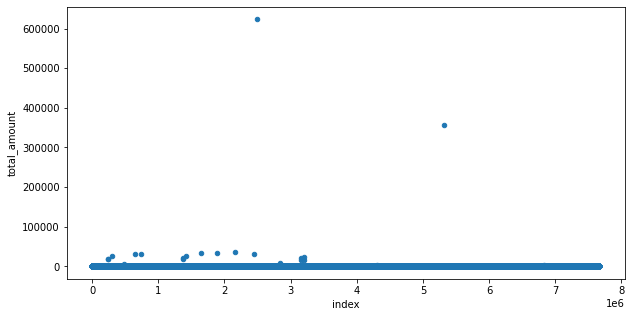

In [12]:
taxi_data.reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

_comment_: very few values above __1000__

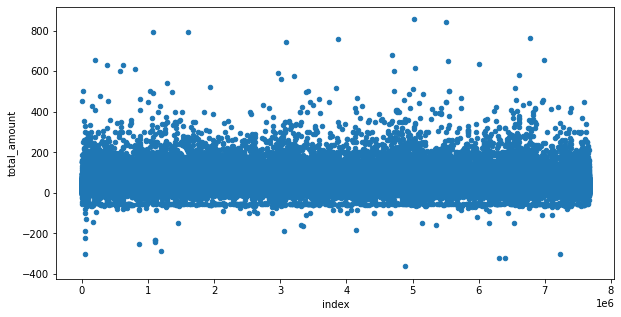

In [13]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

_comment_: once we remove values above 1000, we still see __negative values__

In [14]:
print(taxi_data[taxi_data['total_amount']<0].shape)

(7131, 9)


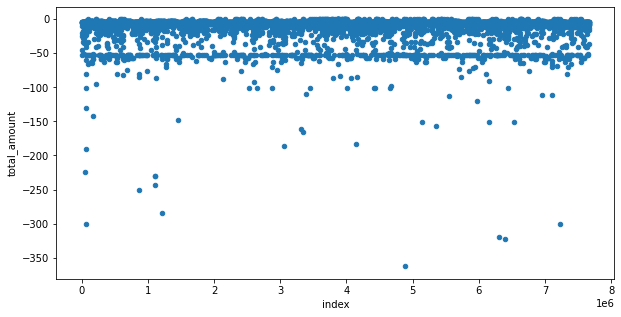

In [15]:
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

In [16]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


In [17]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

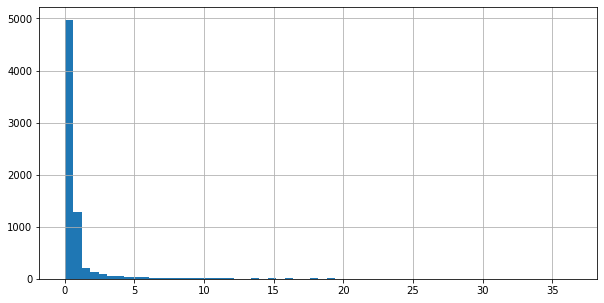

In [18]:
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60,figsize=(10,5));

we can safely remove the data containing a __negative total amount__

In [19]:
print(taxi_data[taxi_data['total_amount']==0].shape)

(1414, 9)


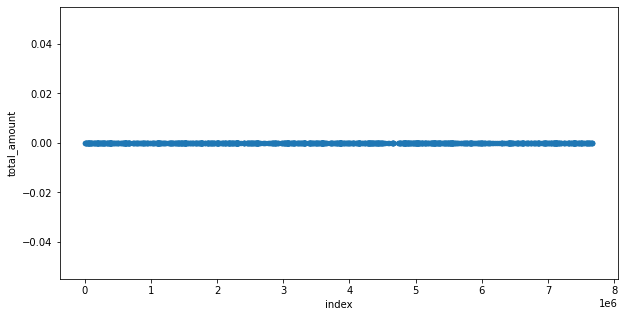

In [20]:
taxi_data[taxi_data['total_amount']==0].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

In [21]:
taxi_data[taxi_data['total_amount']==0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [22]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

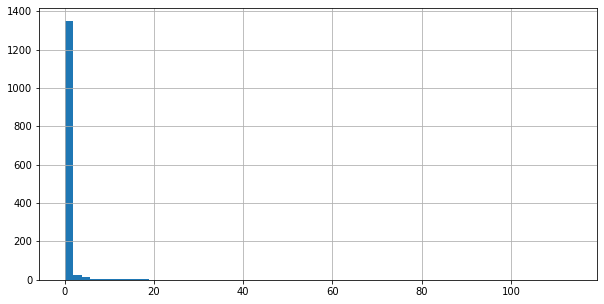

In [23]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60,figsize=(10,5));

In [24]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

what about the high values?

In [25]:
taxi_data[taxi_data['total_amount']>500].shape

(56, 9)

In [26]:
taxi_data[taxi_data['total_amount']>300].shape

(307, 9)

In [27]:
taxi_data[taxi_data['total_amount']>100].shape

(10832, 9)

In [28]:
taxi_data[taxi_data['total_amount']>200].shape

(1166, 9)

In [29]:
taxi_data['total_amount'].mean()

15.68222215991253

We will cut on 200$, seems a fair level.

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [30]:
taxi_data_fltr = taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [31]:
taxi_data_fltr.shape

(7659490, 9)

_checking missing values_

In [32]:
taxi_data_fltr.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

a _deep copy_ creates a new address of the dataframe in memory preserving the original one 

In [33]:
taxi_data_prepared = taxi_data_fltr.copy()

In [34]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

fixing types

In [35]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [36]:
taxi_data_prepared.loc[:,'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [37]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [38]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)

In [39]:
taxi_data_prepared['transaction_year'] = taxi_data_prepared['transaction_date'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['transaction_date'].dt.month
taxi_data_prepared['transaction_day'] = taxi_data_prepared['transaction_date'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [40]:
taxi_data_prepared.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15
5,2018-11-28 16:25:49,2018-11-28 16:28:26,5,0.0,1,193,193,2,13.31,2018-11-28,2018,11,28,16
6,2018-11-28 16:29:37,2018-11-28 16:33:43,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,16
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05,2019-01-01,2019,1,1,0
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50,2019-01-01,2019,1,1,0
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00,2019-01-01,2019,1,1,0


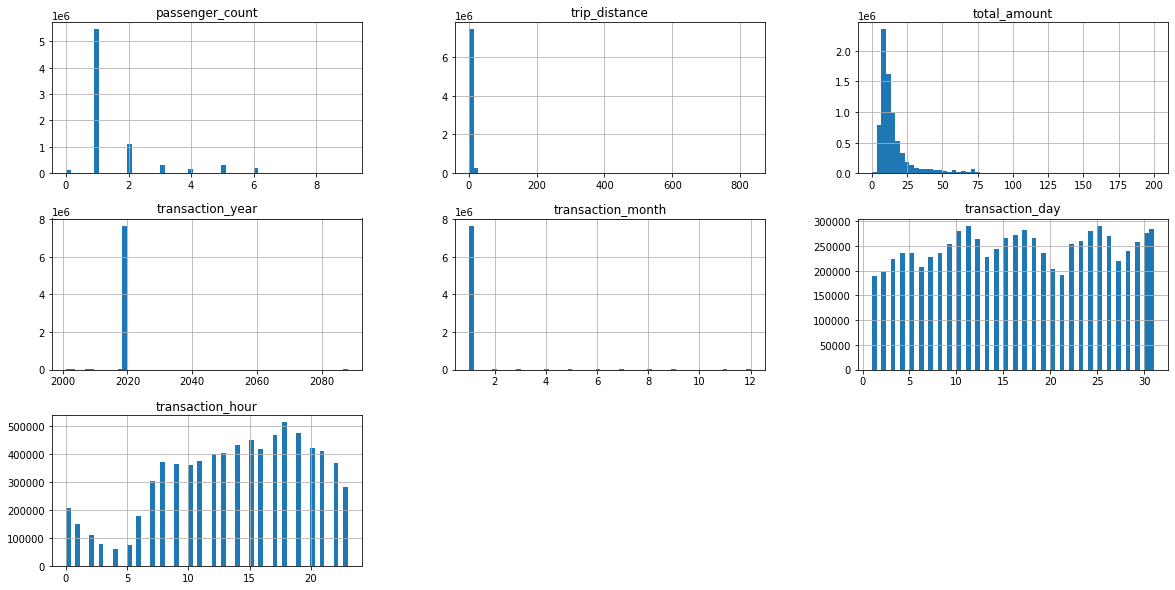

In [41]:
taxi_data_prepared.hist(figsize=(20,10),bins=60);

In [42]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

In [43]:
taxi_data_prepared.shape

(7658954, 14)

In [44]:
taxi_data_prepared.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'transaction_date', 'transaction_year',
       'transaction_month', 'transaction_day', 'transaction_hour'],
      dtype='object')

noting down columns

In [45]:
cat_clmns = ['PULocationID','transaction_date','transaction_month', 'transaction_day', 'transaction_hour']
num_clmns = ['trip_distance','total_amount']
all_clmns = cat_clmns + num_clmns

In [46]:
main_taxi_df = taxi_data_prepared[all_clmns]
print(main_taxi_df.shape)
main_taxi_df.head(3)

(7658954, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05


aggregate data

In [47]:
taxi_grpd_by_region = main_taxi_df.groupby(cat_clmns).mean().reset_index()

In [48]:
taxi_grpd_by_region['count_of_transactions'] = main_taxi_df.groupby(cat_clmns).count().reset_index()['total_amount']

In [49]:
taxi_grpd_by_region.shape

(102556, 8)

In [50]:
taxi_grpd_by_region.head(5)

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


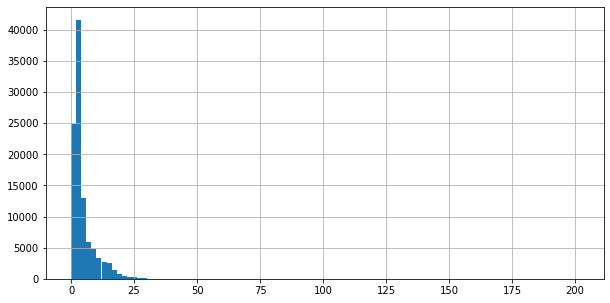

In [51]:
taxi_grpd_by_region['trip_distance'].hist(bins=100,figsize=(10,5));

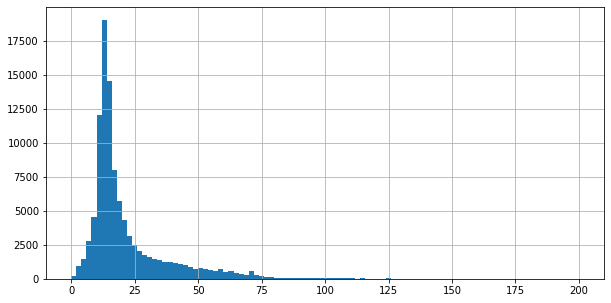

In [52]:
taxi_grpd_by_region['total_amount'].hist(bins=100,figsize=(10,5));

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [53]:
data_bench_model = taxi_grpd_by_region.copy()

In [54]:
cat_ftrs_bench = ['PULocationID',
                  'transaction_month',
                  'transaction_day',
                  'transaction_hour']
# input_ftr_bench = cat_ftrs_bench + ['trip_distance']
input_ftr_bench = cat_ftrs_bench
target_ftr_bench = 'total_amount'

_trip_distance_ is a data leakage! it directly correlates with the the _total_amount_

## __5.1 Train-test split__

In [55]:
from sklearn.model_selection import train_test_split

X_bench = data_bench_model[input_ftr_bench]
y_bench = data_bench_model[target_ftr_bench]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

## __5.2 Fit a model to the data__

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b,y_train_b)

DecisionTreeRegressor(max_depth=10)

## __5.3 Model evaluation__

In [57]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean absolute error +/-', mean_absolute_error(y_test_b,y_pred_b), 'dollars')
print('mean squared error ', mean_squared_error(y_test_b,y_pred_b))
print('root mean squared error', sqrt(mean_squared_error(y_test_b,y_pred_b)))
print('r2 score ', r2_score(y_test_b,y_pred_b), ' how good (1 is perfect, -1 is ugly)')

mean absolute error +/- 9.77699513171978 dollars
mean squared error  217.19078270113098
root mean squared error 14.737394026799004
r2 score  0.22494184560924457  how good (1 is perfect, -1 is ugly)


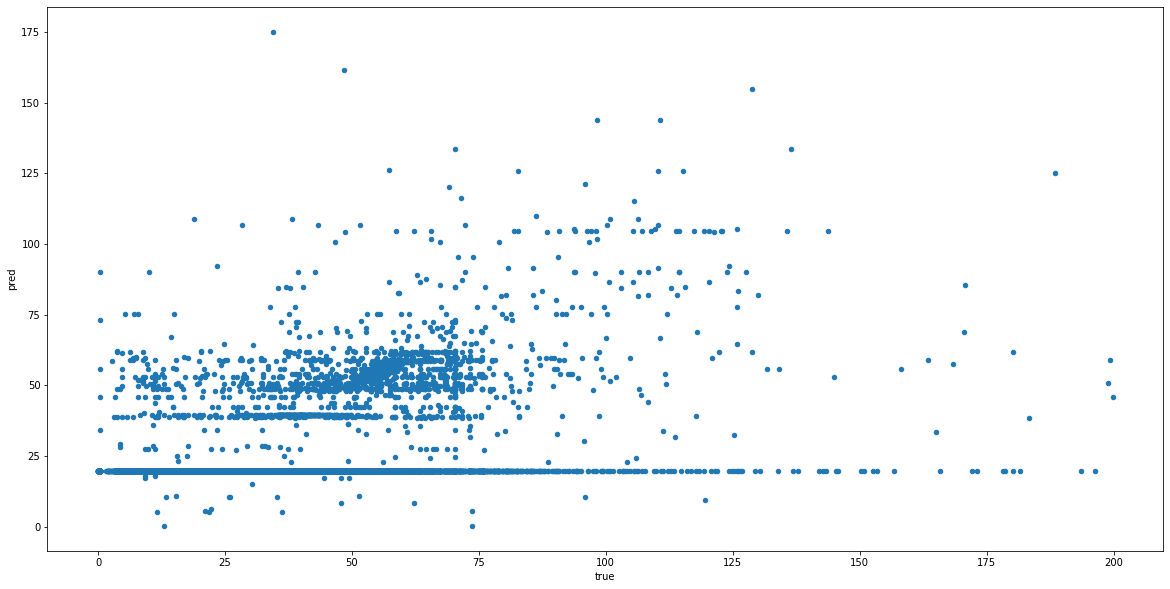

In [58]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred');

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

__Data derived features__

In [59]:
taxi_grpd_by_region.head(5)

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


In [60]:
data_with_new_ftrs = taxi_grpd_by_region.copy()

In [61]:
data_with_new_ftrs['transaction_week_day'] = data_with_new_ftrs['transaction_date'].dt.weekday
data_with_new_ftrs['weekend'] = data_with_new_ftrs['transaction_date'].apply(lambda x: True if x == 5 or x == 6 else False)

In [62]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar
holidays = cal.holidays(cal,start='2018',end='2020').date

data_with_new_ftrs['is_holiday'] = data_with_new_ftrs['transaction_date'].isin(holidays)

In [63]:
data_with_new_ftrs.head(3)

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2019-01-01,1,1,2,0.0,21.8,1,1,False,True
1,1,2019-01-01,1,1,5,0.0,87.3,1,1,False,True
2,1,2019-01-01,1,1,6,0.0,80.3,1,1,False,True


__Borough Information__

In [64]:
zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID','Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [65]:
data_with_new_ftrs = data_with_new_ftrs.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
data_with_new_ftrs.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,1,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,1,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,1,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,1,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,1,EWR


In [66]:
data_with_new_ftrs.Borough.value_counts()

Manhattan        45309
Brooklyn         23633
Queens           22002
Bronx             9586
Unknown           1453
Staten Island      302
EWR                271
Name: Borough, dtype: int64

__Weather related information__

In [67]:
nyc_weather = pd.read_csv('data/nyc_weather.csv')
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,100%.,0.3
1,31.12.2019 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2019 16:00,7.2,66,5,50%.,NaN
3,31.12.2019 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2019 10:00,4.4,83,2,100%.,Trace of precipitation


In [68]:
nyc_weather.shape

(2936, 6)

In [69]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object

In [70]:
nyc_weather['cloud cover'].value_counts()

70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: cloud cover, dtype: int64

In [71]:
nyc_weather['amount of precipitation'].value_counts()

Trace of precipitation    266
0.3                        61
2.0                        49
1.0                        45
0.8                        42
0.5                        42
4.0                        33
5.0                        24
3.0                        23
6.0                        19
7.0                        13
8.0                        13
9.0                        11
10.0                       10
13.0                        7
12.0                        7
15.0                        6
11.0                        5
16.0                        3
14.0                        2
22.0                        2
29.0                        2
21.0                        1
24.0                        1
63.0                        1
20.0                        1
18.0                        1
35.0                        1
30.0                        1
34.0                        1
25.0                        1
17.0                        1
68.0                        1
Name: amou

In [72]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
dtype: int64

In [73]:
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].replace('Trace of precipitation',0.1)
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].astype(float)

# filling missing values option 1
# nyc_weather['amount of precipitation'].fillna(0, inplace=True)

# filling missing values option 2
# filling forward, using the last occurring value
# nyc_weather['amount of precipitation'].fillna(method='ffill', inplace=True) 

# filling missing values option 3
# draw the linear line and you take the value between the two occurring values
nyc_weather['amount of precipitation'].interpolate(inplace=True) 

In [74]:
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].map({
    "70 – 80%.":0.7,
    "100%.":1,
    "20–30%.":0.3,
    "50%.":0.5,
    "no clouds":0,
    "Sky obscured by fog and/or other meteorological phenomena.":1,
})

In [75]:
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].astype(float)
nyc_weather['cloud cover'].interpolate(inplace=True)

In [76]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation    float64
dtype: object

In [77]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,1.0,0.300000
1,31.12.2019 19:00,6.7,71,5,0.7,0.233333
2,31.12.2019 16:00,7.2,66,5,0.5,0.166667
3,31.12.2019 13:00,6.1,76,3,1.0,0.100000
4,31.12.2019 10:00,4.4,83,2,1.0,0.100000


In [78]:
nyc_weather.loc[:,'date and time'] = pd.to_datetime(nyc_weather.loc[:,'date and time'])

In [79]:
nyc_weather['hour'] = nyc_weather['date and time'].dt.hour
nyc_weather['day'] = nyc_weather['date and time'].dt.day
nyc_weather['month'] = nyc_weather['date and time'].dt.month

In [80]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,day,month
0,2019-12-31 22:00:00,6.1,65,6,1.0,0.300000,22,31,12
1,2019-12-31 19:00:00,6.7,71,5,0.7,0.233333,19,31,12
2,2019-12-31 16:00:00,7.2,66,5,0.5,0.166667,16,31,12
3,2019-12-31 13:00:00,6.1,76,3,1.0,0.100000,13,31,12
4,2019-12-31 10:00:00,4.4,83,2,1.0,0.100000,10,31,12


In [81]:
nyc_taxi_with_weather = data_with_new_ftrs.merge(nyc_weather,
                                                 left_on=['transaction_day','transaction_hour','transaction_month'],
                                                 right_on=['day','hour','month'], how='left')

In [82]:
nyc_taxi_with_weather.isna().sum()

PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
LocationID                     0
Borough                        0
date and time              68371
temperature                68371
humidity                   68371
wind speed                 68371
cloud cover                68371
amount of precipitation    68371
hour                       68371
day                        68371
month                      68371
dtype: int64

In [83]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(['date and time','hour','month','day'], axis=1)

In [84]:
nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index(drop=True)

In [85]:
nyc_taxi_with_weather.shape

(102556, 18)

In [86]:
nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather = nyc_taxi_with_weather.fillna(method='bfill')
nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
LocationID                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [87]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,10,Queens,8.3,97.0,0.0,1.0,29.0
1,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,100,Manhattan,8.3,97.0,0.0,1.0,29.0
2,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,106,Brooklyn,8.3,97.0,0.0,1.0,29.0
3,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,107,Manhattan,8.3,97.0,0.0,1.0,29.0
4,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,11,Brooklyn,8.3,97.0,0.0,1.0,29.0


# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [88]:
data_for_model = nyc_taxi_with_weather.copy()

In [89]:
categorical_features = ['PULocationID','transaction_month',
                       'transaction_day','transaction_hour',
                       'transaction_week_day','weekend',
                       'is_holiday','Borough']
input_features = categorical_features + ['temperature',
                                         'humidity',
                                         'wind speed',
                                         'cloud cover',
                                         'amount of precipitation']
target_feature = 'total_amount'

__train-test split__

In [90]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 7.1. Decision tree <a id='decision_tree'></a>

In [91]:
from sklearn.tree import DecisionTreeRegressor

# decision_tree = DecisionTreeRegressor(max_depth=10)
# overfitting?
decision_tree = DecisionTreeRegressor()

decision_tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [92]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean absolute error +/-', mean_absolute_error(y_test,y_pred), 'dollars')
print('mean squared error ', mean_squared_error(y_test,y_pred))
print('root mean squared error', sqrt(mean_squared_error(y_test,y_pred)))
print('r2 score ', r2_score(y_test,y_pred), ' how good (1 is perfect, -1 is ugly)')

mean absolute error +/- 9.636321366790828 dollars
mean squared error  306.6009492273706
root mean squared error 17.51002424976535
r2 score  -0.08078752397373079  how good (1 is perfect, -1 is ugly)


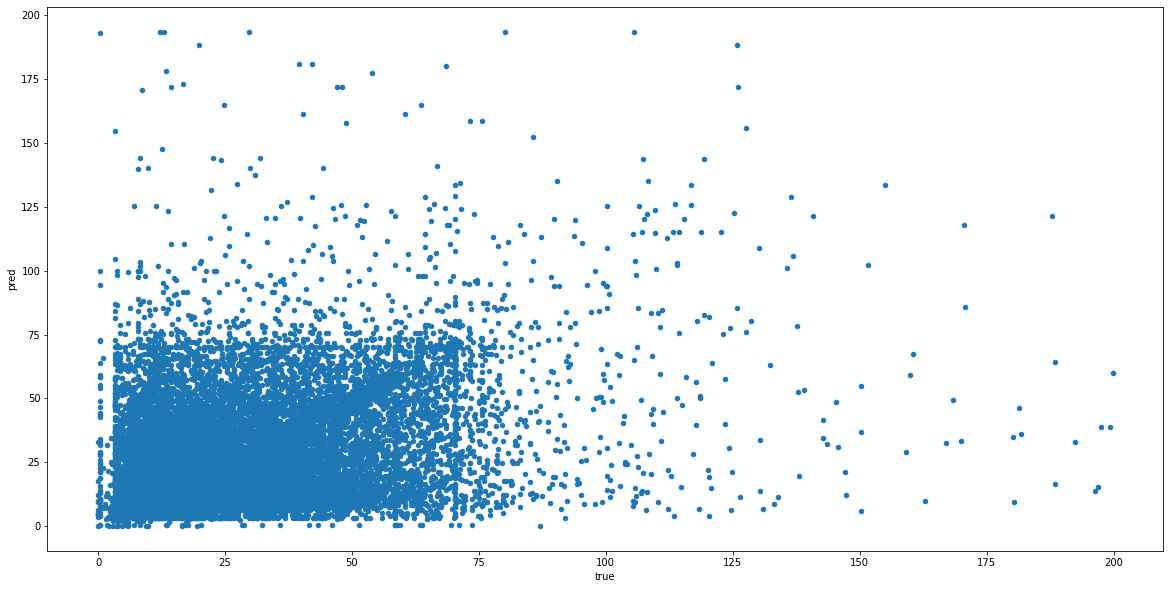

In [93]:
data = {'true': y_test, 'pred': y_pred}

results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred');

__Overfit__

In [94]:
X_train_overfit = X_train
y_train_overfit = y_train

X_test_overfit = X_test
y_test_overfit = y_test

In [95]:
rmse_scores = {'max_depth':[], 'rmse_train':[],'rmse_test':[]}

In [96]:
for md in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 150]:
    print(md)
    decision_tree_overfit = DecisionTreeRegressor(max_depth=md)
    decision_tree_overfit.fit(X_train_overfit,y_train_overfit)
    
    model_at_hand_overfit = decision_tree_overfit
    
    y_pred_train = model_at_hand_overfit.predict(X_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_train_overfit, y_pred_train))
    
    y_pred_test = model_at_hand_overfit.predict(X_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_test_overfit, y_pred_test))
    
    rmse_scores['max_depth'].append(md)
    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)

2
5
8
10
15
20
30
50
70
100
150


In [97]:
pd.DataFrame.from_dict(rmse_scores)

,max_depth,rmse_train,rmse_test
0,2,1.495163e+01,15.174393
1,5,1.412253e+01,14.497210
2,8,1.352369e+01,14.172637
3,10,1.313962e+01,14.047925
4,15,1.204887e+01,14.354968
5,20,1.109997e+01,14.590625
6,30,9.498728e+00,15.000557
7,50,5.425101e+00,16.629284
8,70,1.124528e+00,17.459087
9,100,6.561446e-17,17.473858


Text(0, 0.5, 'root mean squared error')

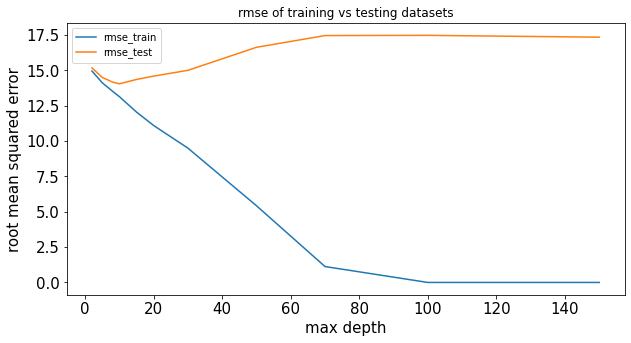

In [98]:
ax = pd.DataFrame.from_dict(rmse_scores).plot(figsize=(10,5),
                                             title='rmse of training vs testing datasets',
                                             fontsize=15,
                                             x='max_depth');
ax.set_xlabel("max depth", fontsize=15)
ax.set_ylabel("root mean squared error", fontsize=15)

__Underfit__

In [99]:
X_train_underfit = X_train
y_train_underfit = y_train

X_test_underfit = X_test
y_test_underfit = y_test

In [100]:
decision_tree_underfit = DecisionTreeRegressor(max_depth=1)
decision_tree_underfit.fit(X_train_underfit, y_train_underfit)

# Training performance

model_at_hand_underfit = decision_tree_underfit

y_pred_underfit = model_at_hand_underfit.predict(X_train_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_train_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_train_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_train_underfit, y_pred_underfit)))
print('r2', r2_score(y_train_underfit, y_pred_underfit))

mean_absolute_error 9.947300430991666
mean_squared_error 239.08086416457166
root_mean_squared_error 15.462239946546285
r2 0.12373835366276398


In [101]:
# Testing performance

y_pred_underfit = model_at_hand_underfit.predict(X_test_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_test_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_underfit, y_pred_underfit)))
print('r2', r2_score(y_test_underfit, y_pred_underfit))

mean_absolute_error 10.082374129980249
mean_squared_error 249.23442786807357
root_mean_squared_error 15.787160221777492
r2 0.12143305210453104



## 7.2. Random forest <a id='random_forest'></a>

In [102]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()

rando_model.fit(X_train,y_train)

RandomForestRegressor()

In [107]:
model_at_hand = rando_model

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean absolute error +/-', mean_absolute_error(y_test,y_pred), 'dollars')
print('mean squared error ', mean_squared_error(y_test,y_pred))
print('root mean squared error', sqrt(mean_squared_error(y_test,y_pred)))
print('r2 score ', r2_score(y_test,y_pred), ' how good (1 is perfect, -1 is ugly)')

mean absolute error +/- 7.433432942544775 dollars
mean squared error  175.2992597372188
root mean squared error 13.240062678749629
r2 score  0.38205914442451705  how good (1 is perfect, -1 is ugly)


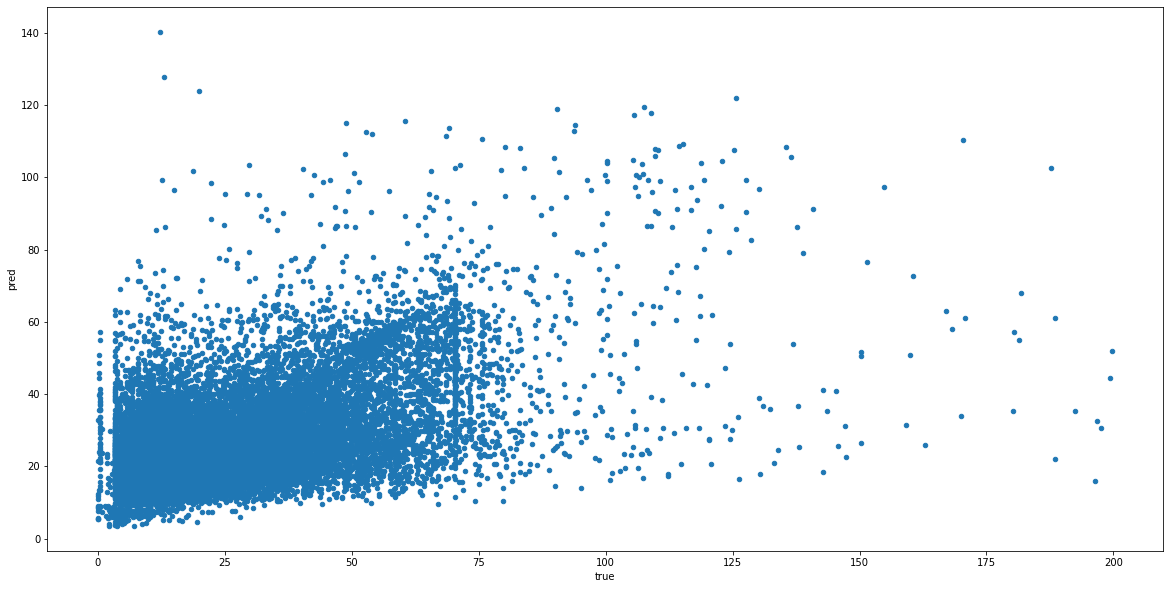

In [108]:
data = {'true': y_test, 'pred': y_pred}

results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred');

## 7.3. Gradient Booster <a id='gradient_booster'></a>

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

gradBooster = GradientBoostingRegressor()

gradBooster.fit(X_train,y_train)

GradientBoostingRegressor()

In [109]:
model_at_hand = gradBooster

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean absolute error +/-', mean_absolute_error(y_test,y_pred), 'dollars')
print('mean squared error ', mean_squared_error(y_test,y_pred))
print('root mean squared error', sqrt(mean_squared_error(y_test,y_pred)))
print('r2 score ', r2_score(y_test,y_pred), ' how good (1 is perfect, -1 is ugly)')

mean absolute error +/- 8.38841366283622 dollars
mean squared error  179.00674859609813
root mean squared error 13.37934036476007
r2 score  0.3689900142928394  how good (1 is perfect, -1 is ugly)


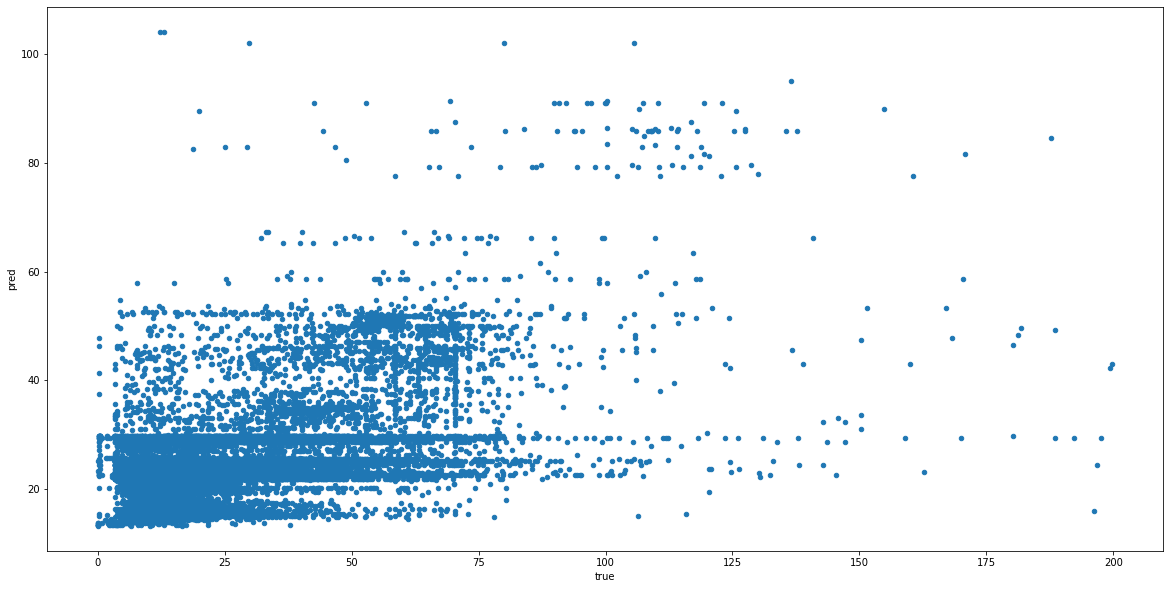

In [110]:
data = {'true': y_test, 'pred': y_pred}

results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred');

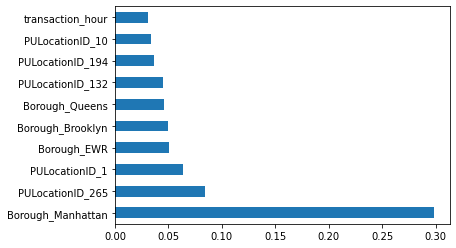

In [112]:
(pd.Series(model_at_hand.feature_importances_, index=X_train.columns)
    .nlargest(10)
    .plot(kind='barh'));

## 7.4. Comparing Perfomance <a id='comparing_model_performance'></a>

| Algorithm         |  MAE  |  RMSE  |   R2   |
|-------------------|:-----:|:------:|:------:|
| Benchmark model   | 9.778 | 14.739 |  0.225 |
| Decision tree     | 8.534 | 14.011 |  0.308 |
| Random forest     | 7.426 | 13.212 |  0.385 |
| Gradient boosting | 8.388 | 13.378 |  0.369 |

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

## 8.1 Find best parameters

In [118]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto','sqrt']
max_depth = [10,20,50,100,150,200,300,500]
max_depth.append(None)
min_samples_split = [2,5,10,20,40]
min_samples_leaf = [1,2,4,10,20]
bootstrap = [True,False]

In [123]:
import pprint as pp

random_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100, 150, 200, 300, 500, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 5, 10, 20, 40],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [124]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid,
                              n_iter=10, cv=3, verbose=2,
                              random_state=42,n_jobs=-1)

rf_random.fit(X_train, y_train)

performances = pd.DataFrame.from_dict(rf_random.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 115.8min finished


In [125]:
performances

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,98.206369,3.733105,6.557278,0.884613,200,10,1,sqrt,200,False,"{'n_estimators': 200, 'min_samples_split': 10,...",0.402215,0.416628,0.413342,0.410728,0.006167,3
1,31.524548,5.829268,2.781176,0.245625,200,5,4,sqrt,20,True,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.356884,0.368694,0.362172,0.362583,0.004830,7
2,43.294657,0.537349,2.469632,0.160028,200,40,4,sqrt,20,False,"{'n_estimators': 200, 'min_samples_split': 40,...",0.355855,0.372823,0.363789,0.364156,0.006932,5
3,753.306151,14.214676,4.719696,0.540061,400,40,10,auto,20,False,"{'n_estimators': 400, 'min_samples_split': 40,...",0.351961,0.365844,0.361048,0.359618,0.005757,8
4,2497.512379,142.564907,11.647659,0.633925,1000,20,20,auto,50,False,"{'n_estimators': 1000, 'min_samples_split': 20...",0.350632,0.365687,0.375448,0.363922,0.010207,6
5,636.077980,66.975276,28.550216,7.434932,1200,5,1,sqrt,100,False,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.384004,0.396514,0.392108,0.390875,0.005181,4
6,85.363816,5.786224,4.732990,0.106014,1400,5,20,sqrt,10,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.269724,0.279420,0.272002,0.273715,0.004139,9
7,271.241625,17.934262,16.230211,0.436971,1400,10,10,sqrt,None,True,"{'n_estimators': 1400, 'min_samples_split': 10...",0.402632,0.419827,0.410841,0.411100,0.007022,2
8,3566.019573,108.325734,15.646873,1.774571,1800,10,2,auto,50,False,"{'n_estimators': 1800, 'min_samples_split': 10...",0.213932,0.213856,0.190966,0.206251,0.010809,10
9,189.289718,8.973897,8.396664,0.149516,600,10,2,sqrt,500,False,"{'n_estimators': 600, 'min_samples_split': 10,...",0.411782,0.427543,0.422729,0.420685,0.006595,1


__Testing the parameters which performed the best__

In [126]:
from sklearn.ensemble import RandomForestRegressor

import time
t0= time.time()

second_best = RandomForestRegressor(n_estimators=600,min_samples_split= 10,
min_samples_leaf= 2,
max_features= 'sqrt',
max_depth= 500,
bootstrap= False)
second_best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = second_best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  179.61893272399902  seconds
mean_absolute_error 7.3259450097391055
mean_squared_error 162.45818066759006
root_mean_squared_error 12.745908389267123
r2 0.427324751356878


<AxesSubplot:xlabel='true', ylabel='pred'>

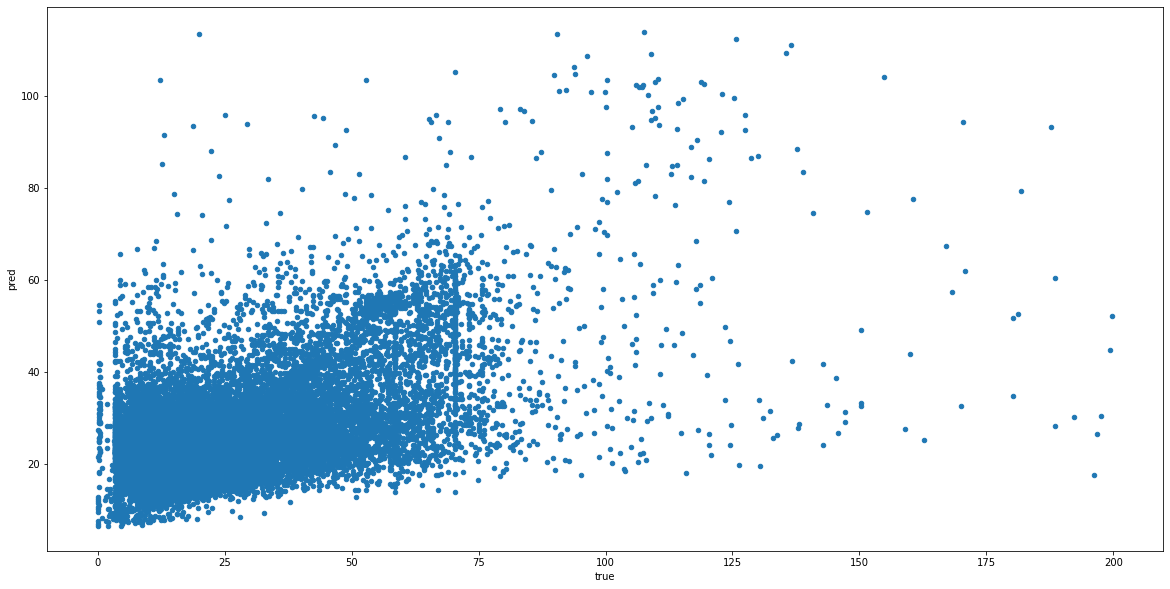

In [127]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')